## 1. Introduction

*to be filled*

## 2. Executive Summary

*to be filled*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import warnings
from scipy import stats
from scipy.stats import skew, norm
from sklearn import linear_model #to build the model
from sklearn.metrics import mean_squared_error #to evaluate the model
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNet, LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_val_predict
import pandas_profiling
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [2]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

In [3]:
print(train.shape)
print(test.shape)

(2051, 81)
(879, 80)


In [4]:
#Observation for first 10 rows of data
train.head(10)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500
5,138,535126040,20,RL,137.0,16492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,6,2010,WD,190000
6,2827,908186070,180,RM,35.0,3675,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,6,2006,New,140000
7,145,535154050,20,RL,NaN,12160,Pave,NaN,IR1,Lvl,...,0,0,NaN,MnPrv,NaN,0,5,2010,COD,142000
8,1942,535353130,20,RL,NaN,15783,Pave,NaN,Reg,Lvl,...,0,0,NaN,MnPrv,Shed,400,6,2007,WD,112500
9,1956,535426130,60,RL,70.0,11606,Pave,NaN,IR1,HLS,...,0,0,NaN,NaN,NaN,0,9,2007,WD,135000


In [5]:
#Removing spaces in column names
train.columns = train.columns.map(lambda column: column.replace(' ',''))
test.columns = test.columns.map(lambda column: column.replace(' ',''))

In [6]:
#tool for detailed univariate analysis
# train.profile_report()

## 3. Removal of anomalies in independent numerical variables

In [7]:
#Scatter plot function to further explore standout features from report
def scatter(feature):
    fig = plt.figure(figsize=(15,8))
    ax = plt.gca()
    x = train[feature]
    y = train.SalePrice
    plt.title('Scatter Plot',fontsize=16,fontweight='bold')
    plt.xlabel(feature,fontsize=16)
    plt.ylabel('Sales Price',fontsize=16)

    ax.scatter(x, y, c='k');

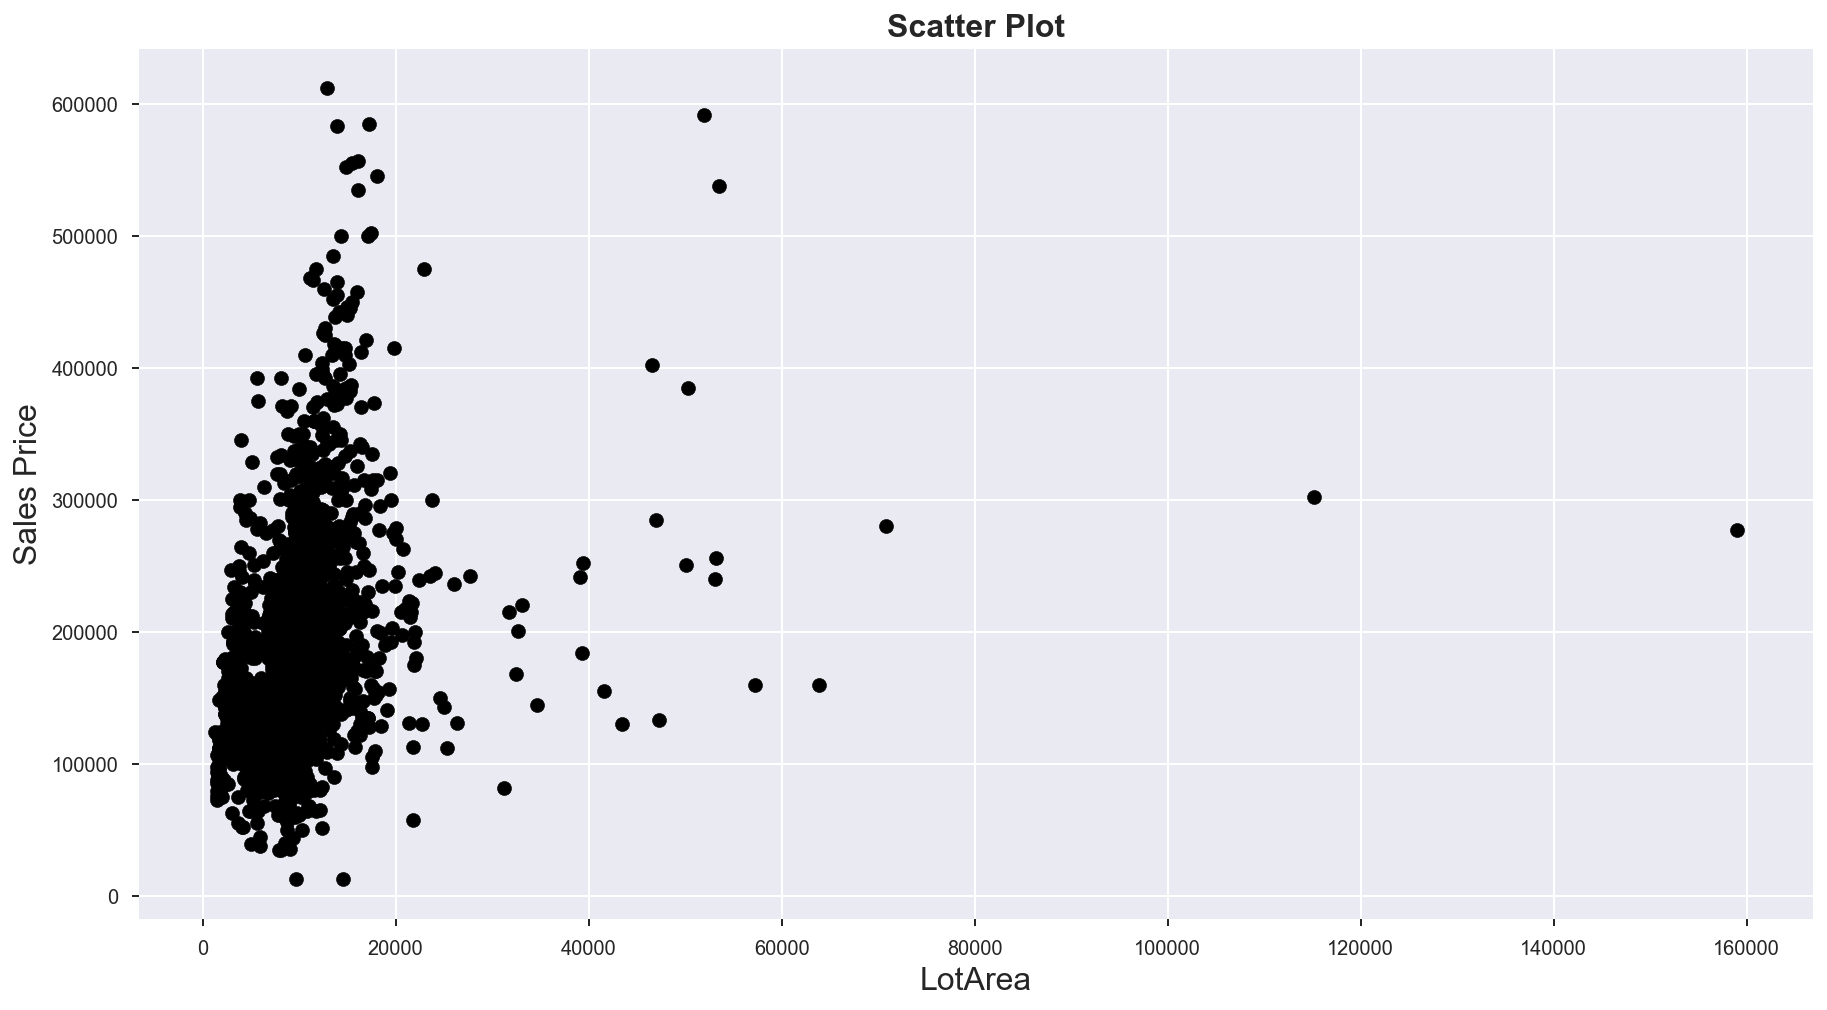

In [8]:
# Visually check for presence of anomalies in Lot Area
scatter('LotArea')

In [9]:
#Drop anomalies where lot area >70,000 - left 2048 observations
train.drop(train[train['LotArea']>70000].index,inplace=True)

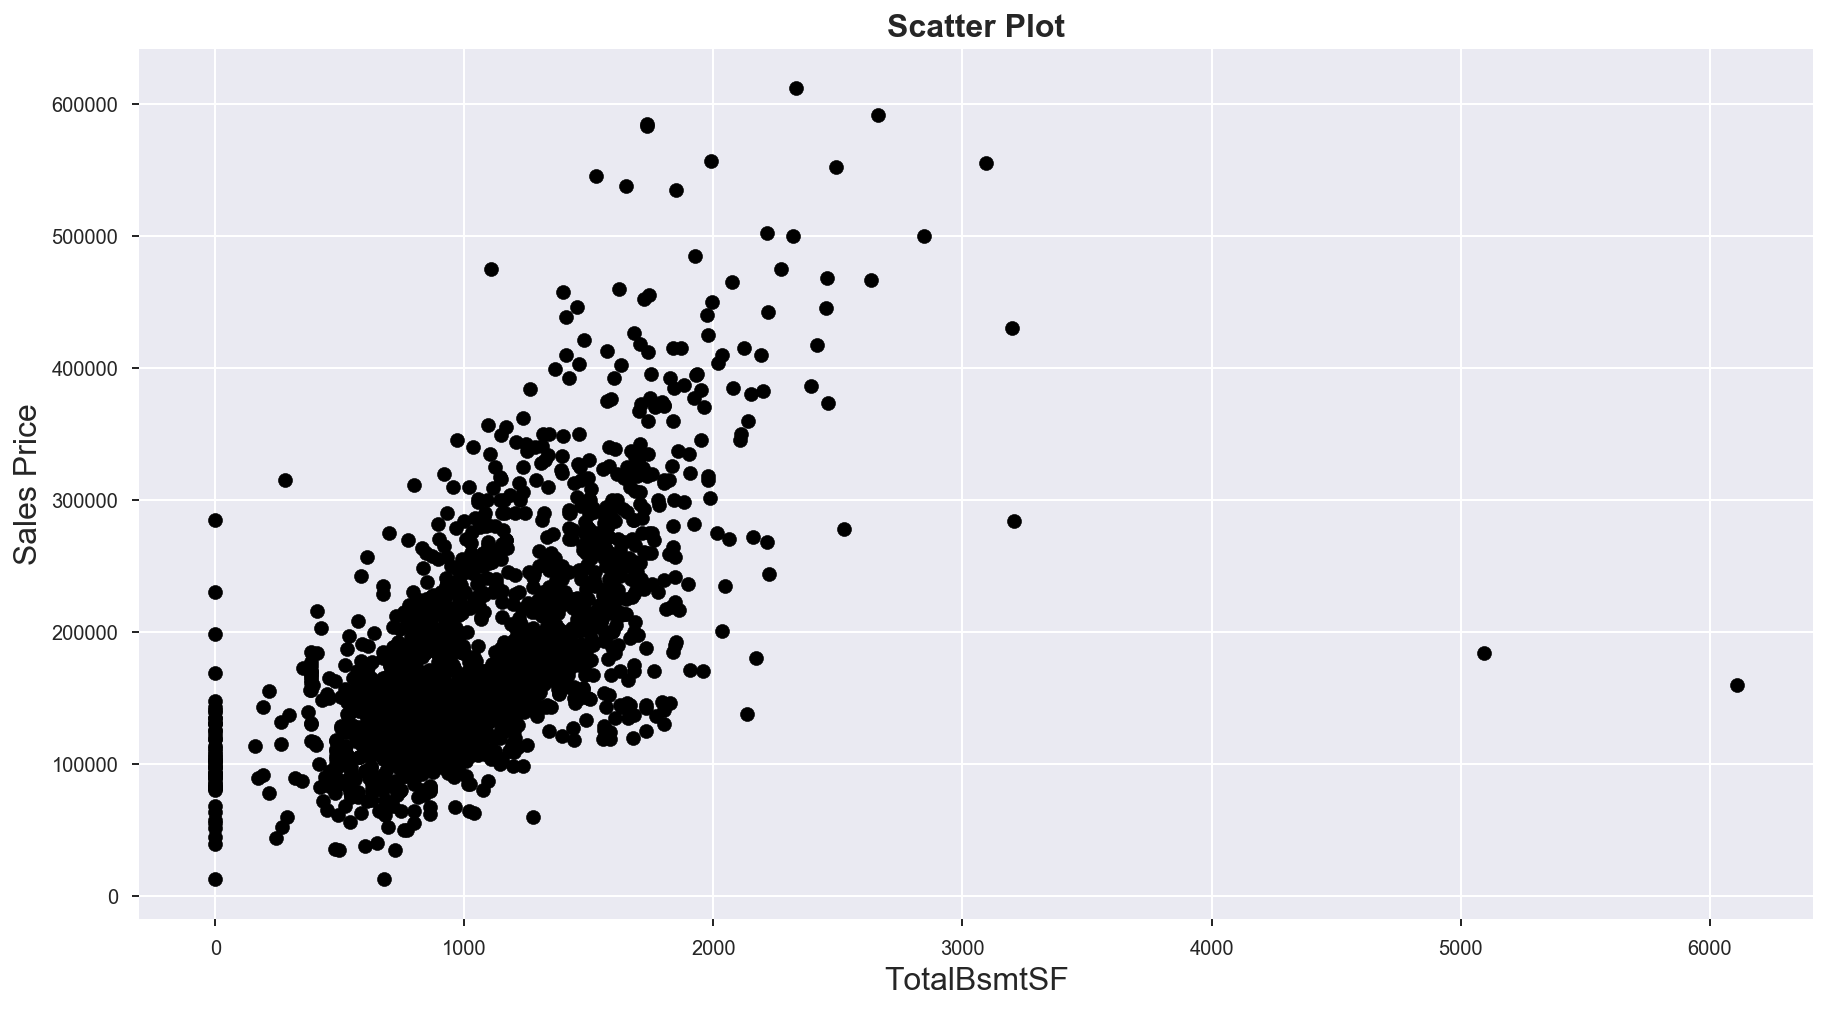

In [10]:
# Visually check for presence of anomalies in Total Bsmt 
scatter('TotalBsmtSF')

In [11]:
#Drop anomalies where total bsmt sf > 4,000- left 2046 observations
train.drop(train[train['TotalBsmtSF']>4000].index,inplace=True)

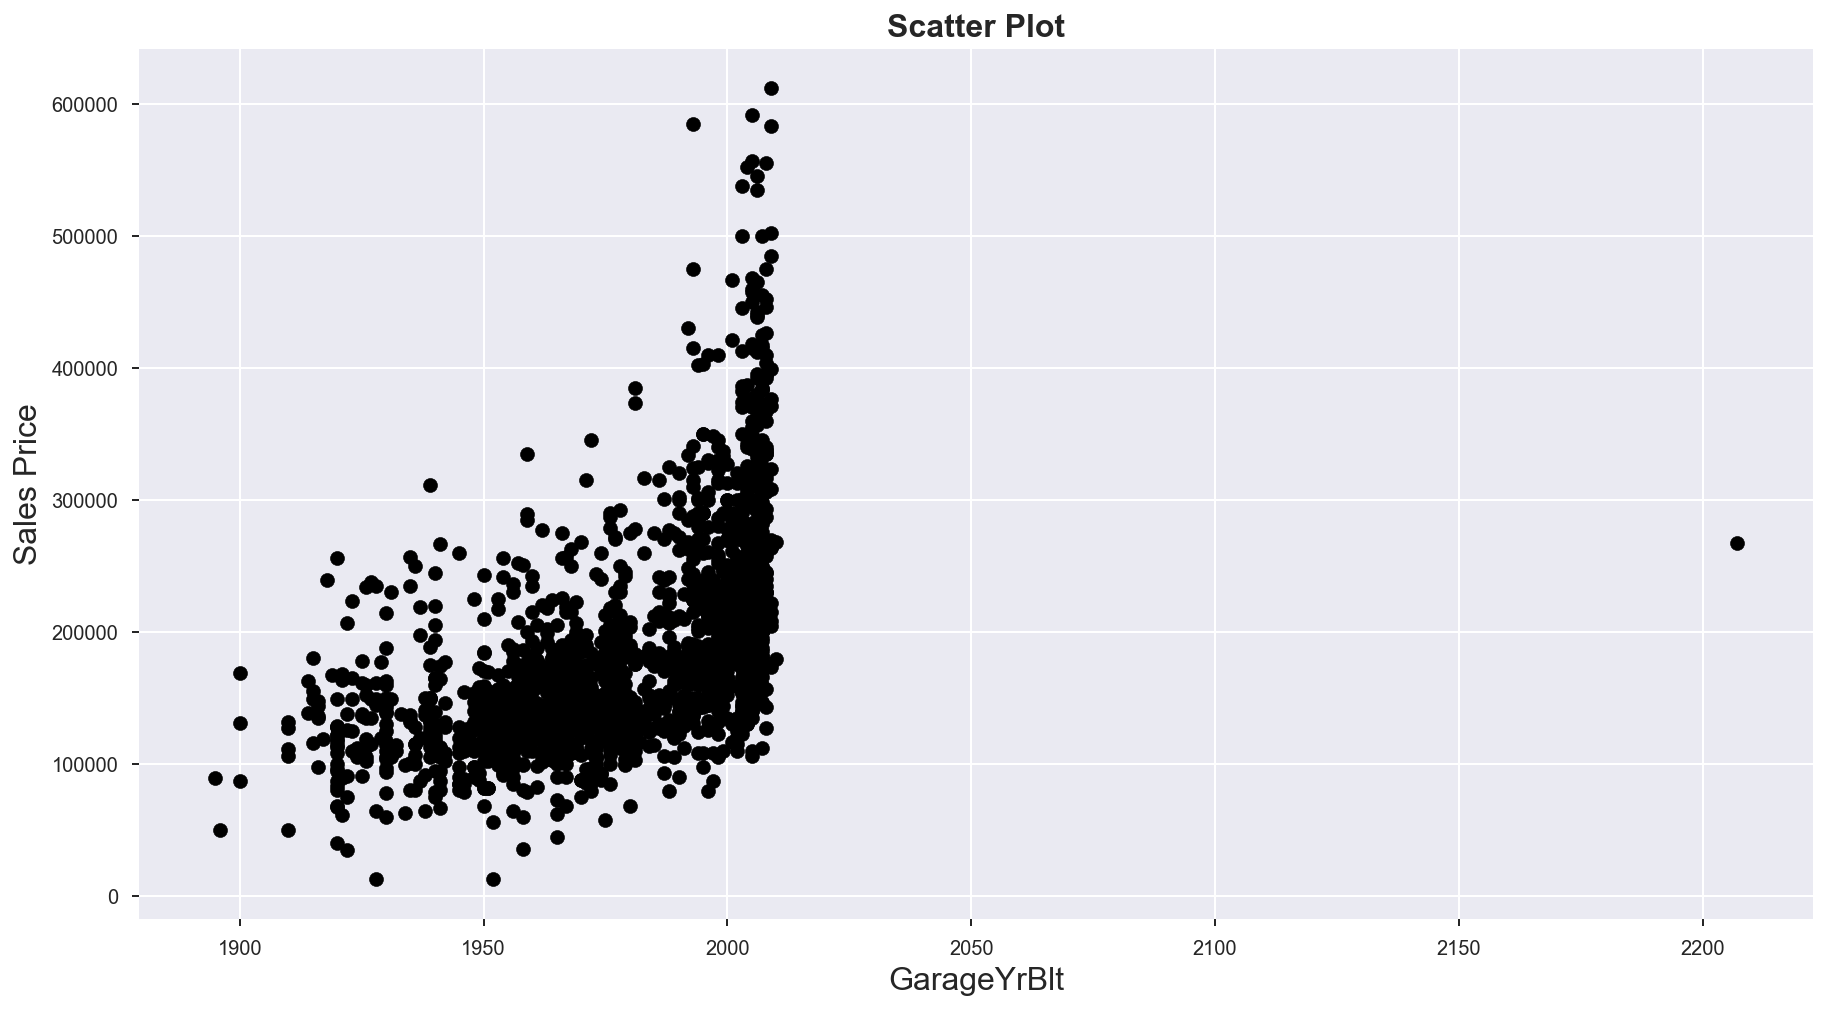

In [12]:
# Visually check for presence of anomalies in Garage Yr Blt
scatter('GarageYrBlt')

In [13]:
#Changing value of anomaly in GarageYrBlt, with the assumption that its a wrong entry, to a reasonable correction.
train.at[1699,'GarageYrBlt'] = 2007

In [14]:
#Removing anomaly in LotArea feature in test
test.at[214,'LotArea'] = test['LotArea'].median()

## 4. Feature engineering for independent variables

1. To clean null values using suitable replacement e.g. To fill null values with 'NA' where it is an option
2. Convert remaining categorical features to numerical equivalent, using reasonable "quality" based scale, and dummy variables

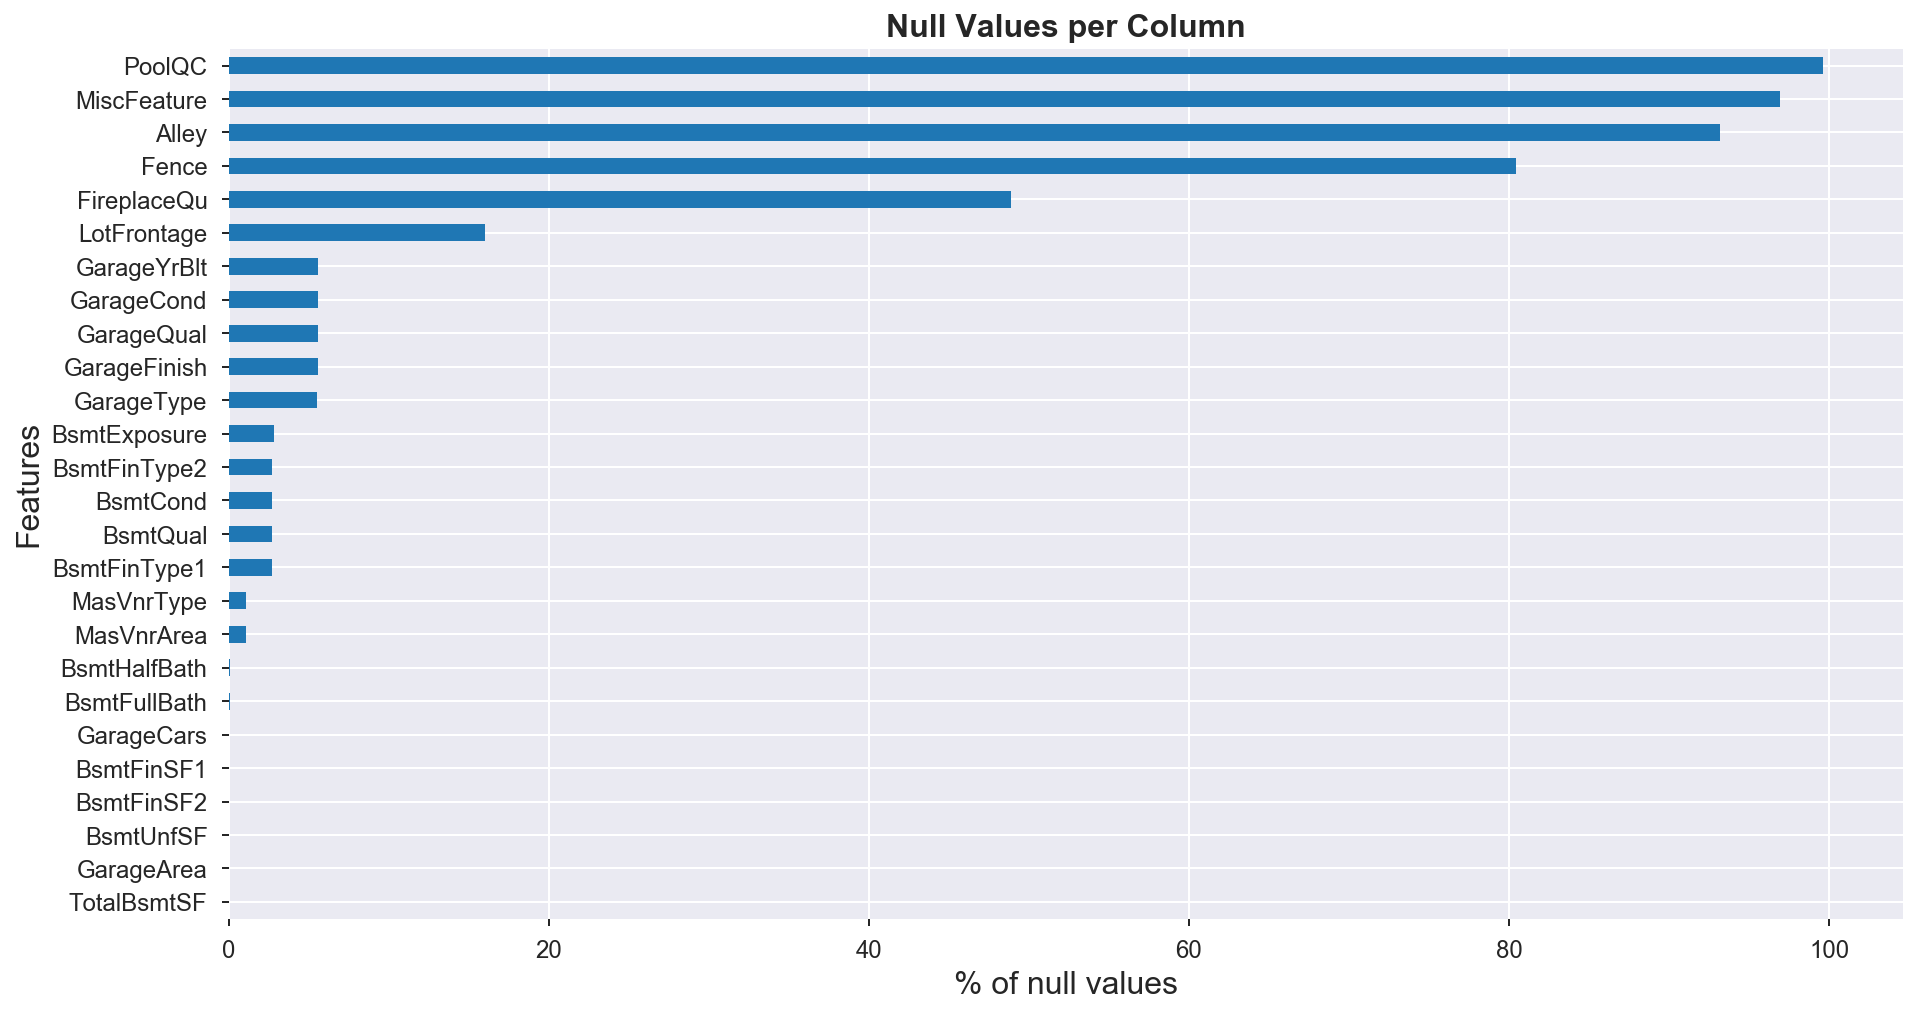

In [15]:
#Barchart representing % of column with missing data
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values()
plt.figure(figsize=(15,8))
plt.xlabel('% of null values',fontsize=16)
plt.ylabel('Features',fontsize=16)
plt.title('Null Values per Column',fontsize=16,fontweight='bold')
train_na.plot(kind='barh',fontsize=12);

## 4.A. Cleaning of initial null values

Cleaning of both categorical and numerical columns, with the exception of those that will be cleaned in section 4.B

In [16]:
#function for filling NaNs
def clean_check_col(df, col,fill_value):
    df[col] = df[col].fillna(fill_value)

In [17]:
#fill NaNs with 'NA', where it is already an option
for i in ['MiscFeature','Alley','Fence','GarageType','BsmtFinType2','BsmtFinType1']:
    clean_check_col(train, i,'NA')
    clean_check_col(test, i,'NA')
    
#fill NaNs with 'None', where it is already an option
for i in ['MasVnrType']:
    clean_check_col(train, i,'None')
    clean_check_col(test, i,'None')

In [18]:
#fill NaNs with mode for discrete variables
for i in ['GarageYrBlt','BsmtHalfBath','BsmtFullBath','GarageCars']:
    clean_check_col(train, i,int(train[i].mode()))
    clean_check_col(test, i,int(train[i].mode()))

In [19]:
#fill NaNs with mean for continuous variables
for i in ['MasVnrArea','GarageArea','TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']:
    clean_check_col(train, i,float(train[i].mean()))
    clean_check_col(test, i,float(train[i].mean()))

In [20]:
#fill NaNs with 0 for Lot Frontage
for i in ['LotFrontage']:
    clean_check_col(train, i,0)
    clean_check_col(test, i,0)

## 4.B. Converting categorical variables

1. To modify quality-based columns into a range of integers with information about their relative "goodness"
2. To modify remaining categorical variables to reasonable integer based columns e.g. dummy variables

In [21]:
# Function to turn "quality" columns into numeric ones, to be applied in next few cells.
def clean_quality_col(df, col, dict_values,fill_value):
    clean_check_col(df, col,fill_value)
    
    for key,value in dict_values.items():
        df[col] = df[col].map(lambda cell: cell.replace(key,str(value)))
    df[col] = df[col].astype(int) 
    return

In [22]:
quality_cols = ['ExterQual','ExterCond','KitchenQual','BsmtQual','HeatingQC','FireplaceQu',
                'GarageQual','GarageCond','BsmtCond','PoolQC']
dict_values = {'Ex': 5,
               'Gd' : 4,
               'TA' : 3,
               'Fa' : 2, 
               'Po' : 1,
               'NA' : 0 }
for col in quality_cols:
    clean_quality_col(train, col, dict_values, "NA")
    clean_quality_col(test, col, dict_values, "NA")

In [23]:
col = 'LandSlope'
dict_values = {'Gtl' : 3,
               'Mod' : 2,
               'Sev' : 1,
               'NA'  : 0 }
clean_quality_col(train, col, dict_values, "NA")
clean_quality_col(test, col, dict_values, "NA")

In [24]:
col = 'BsmtExposure'
dict_values = {'Gd' : 4,
               'Av' : 3,
               'Mn' : 2,
               'No' : 1,
               'NA' : 0 }
clean_quality_col(train, col, dict_values, "NA")
clean_quality_col(test, col, dict_values, "NA")

In [25]:
col = 'GarageFinish'
dict_values = {'Fin' : 3, 
               'RFn' : 2,  
               'Unf' : 1,
               'NA' : 0 }
clean_quality_col(train, col, dict_values, "NA")
clean_quality_col(test, col, dict_values, "NA")

In [26]:
col = 'CentralAir'
dict_values = {'Y' : 1, 
               'N' : 0 }
clean_quality_col(train, col, dict_values, "N")
clean_quality_col(test, col, dict_values, "N")

In [27]:
col = 'Fence'
dict_values = {'GdPrv' : 4,
               'MnPrv' : 3,
               'GdWo' : 2,
               'MnWw'  : 1,
               'NA' : 0}
clean_quality_col(train, col, dict_values, "NA")
clean_quality_col(test, col, dict_values, "NA")

In [28]:
quality_cols = ['BsmtFinType1','BsmtFinType2']
dict_values = {'GLQ': 6,
               'ALQ' : 5,
               'BLQ' : 4,
               'Rec' : 3, 
               'LwQ' : 2,
               'Unf' : 1,
               'NA' : 0}
for col in quality_cols:
    clean_quality_col(train, col, dict_values, "NA")
    clean_quality_col(test, col, dict_values, "NA")

In [29]:
col = 'LotShape'
dict_values = {'Reg' : 4,
               'IR1' : 3,
               'IR2' : 2,
               'IR3' : 1 }
clean_quality_col(train, col, dict_values, "NA")
clean_quality_col(test, col, dict_values, "NA")

In [30]:
col = 'Utilities'
dict_values = {'AllPub' : 4,
               'NoSewr' : 3,
               'NoSeWa' : 2,
               'ELO'  : 1 }
clean_quality_col(train, col, dict_values, "NA")
clean_quality_col(test, col, dict_values, "NA")

In [31]:
col = 'Electrical'
dict_values = {'SBrkr' : 5,
               'FuseA' : 4,
               'FuseF' : 3,
               'FuseP' : 2,
               'Mix'  : 1 }
clean_quality_col(train, col, dict_values, "NA")

In [32]:
col = 'Functional'
dict_values = {'Typ' : 8,
               'Min1' : 7,
               'Min2' : 6,
               'Mod' : 5,
               'Maj1' : 4,
               'Maj2' : 3,
               'Sev' : 2,
               'Sal'  : 1 }
clean_quality_col(train, col, dict_values, "NA")
clean_quality_col(test, col, dict_values, "NA")

In [33]:
col = 'PavedDrive'
dict_values = {'Y' : 3,
               'P' : 2,
               'N' : 1,}
clean_quality_col(train, col, dict_values, "NA")
clean_quality_col(test, col, dict_values, "NA")

In [34]:
#columns left that are categorical, to be transformed using dummy variables, in section 6.
obj_cols = train.select_dtypes([np.object]).columns
obj_cols2 = test.select_dtypes([np.object]).columns
print('Categorical features in train to be converted using dummy variables include: ', '\n', list(obj_cols))
print('\n')
print('Categorical features in test to be converted using dummy variables include: ', '\n',list(obj_cols2))

Categorical features in train to be converted using dummy variables include:  
 ['MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'GarageType', 'MiscFeature', 'SaleType']


Categorical features in test to be converted using dummy variables include:  
 ['MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType']


## 5. Observation for dependent variable

In [35]:
#understanding the statistics of our dependent variable
train['SalePrice'].describe()

count      2046.000000
mean     181325.272727
std       79251.065924
min       12789.000000
25%      129575.000000
50%      162250.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

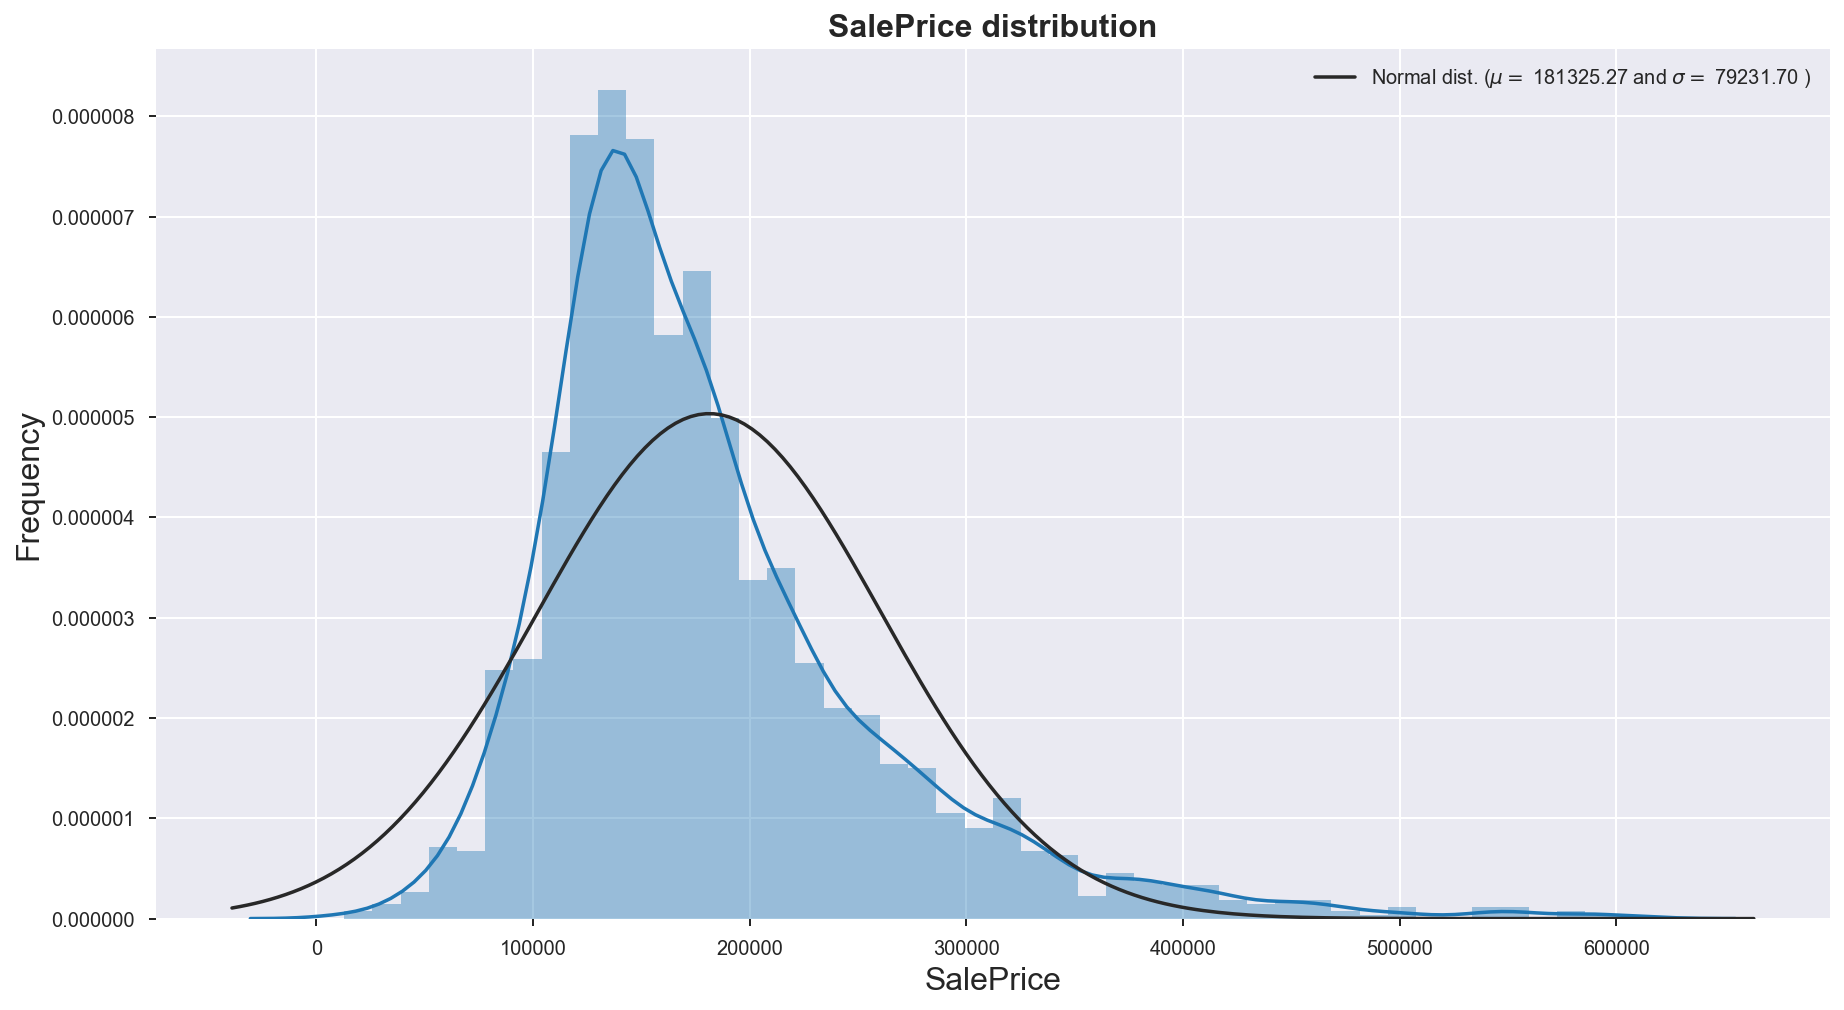

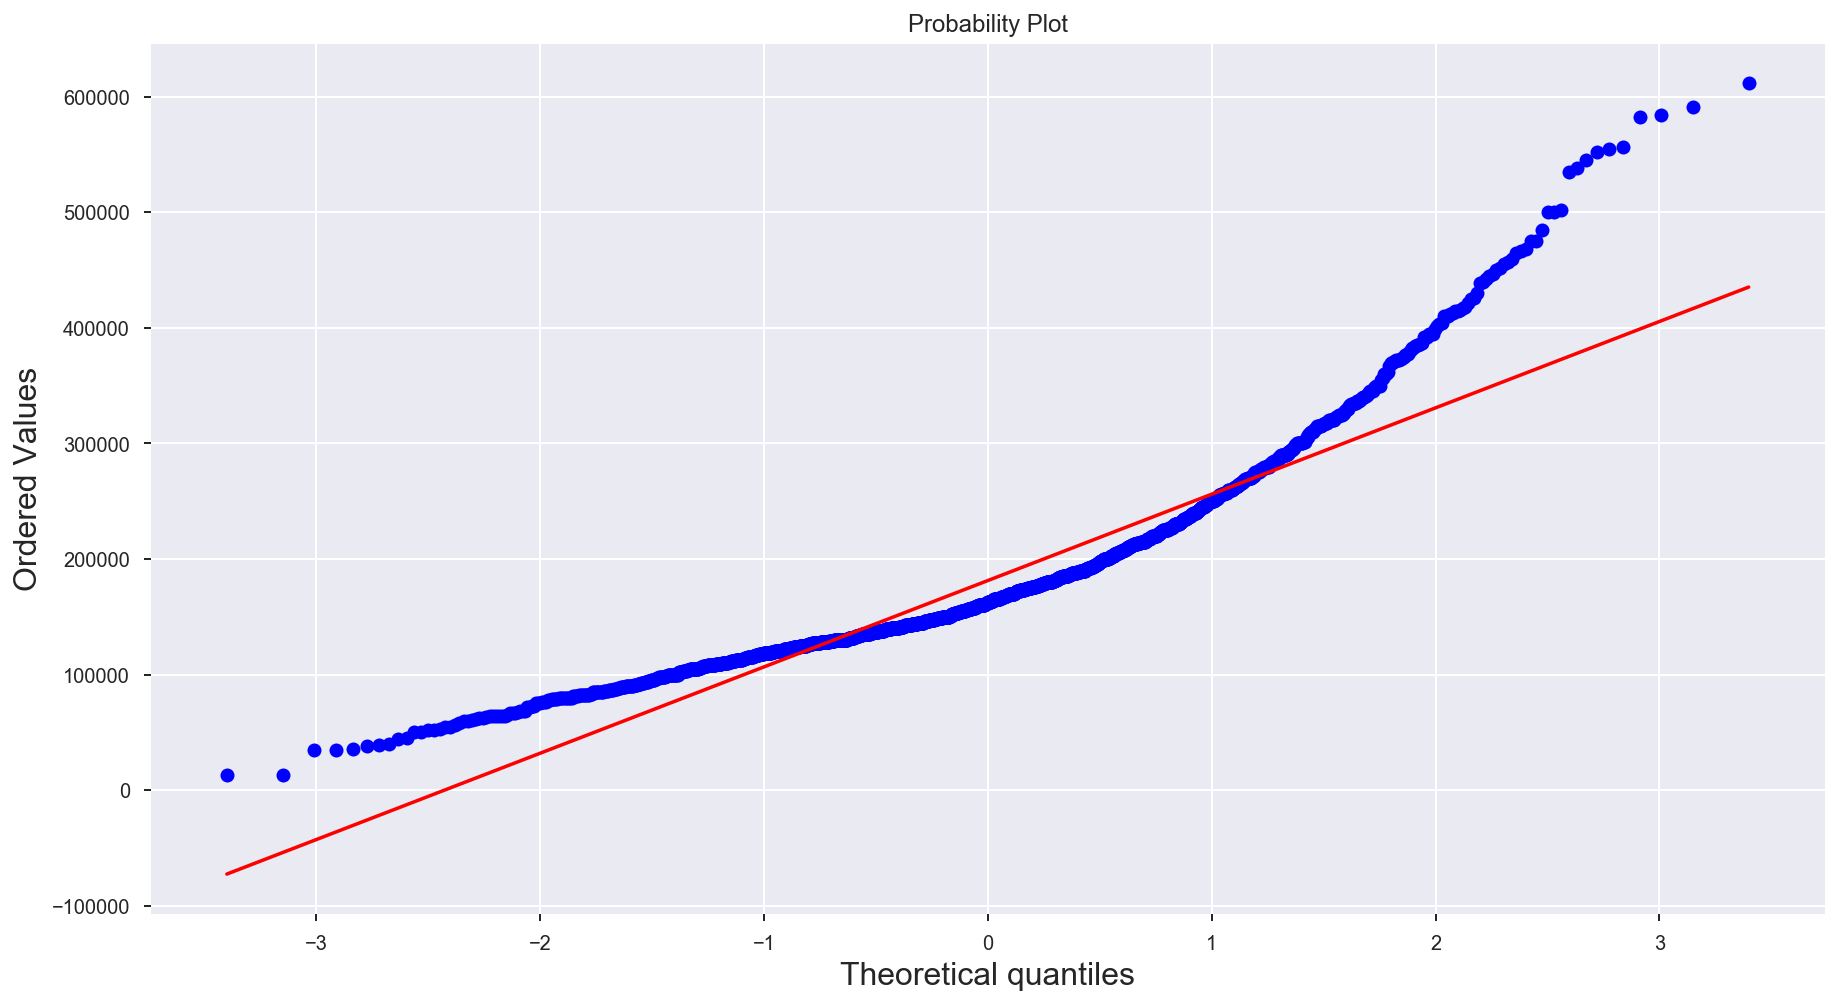

In [36]:
# Kernel Density Plot
plt.figure(figsize=(15,8))
plt.ylabel('Frequency',fontsize=16)
plt.xlabel('SalePrice',fontsize=16)
sns.distplot(train.SalePrice,fit=norm);
plt.title('SalePrice distribution',fontsize=16,fontweight='bold');
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice']);
# QQ-plot
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
fig = plt.figure(figsize=(15,8))
plt.ylabel('Ordered Values',fontsize=16)
plt.xlabel('Theoretical Qualities',fontsize=16)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The above graphs suggest that Sales Price is right skewed, and has peakedness. Since linear regression models fits better on normally distributed data, and performs more "well-behaved", we should normalize the target variable by taking log(feature+1)

In [37]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

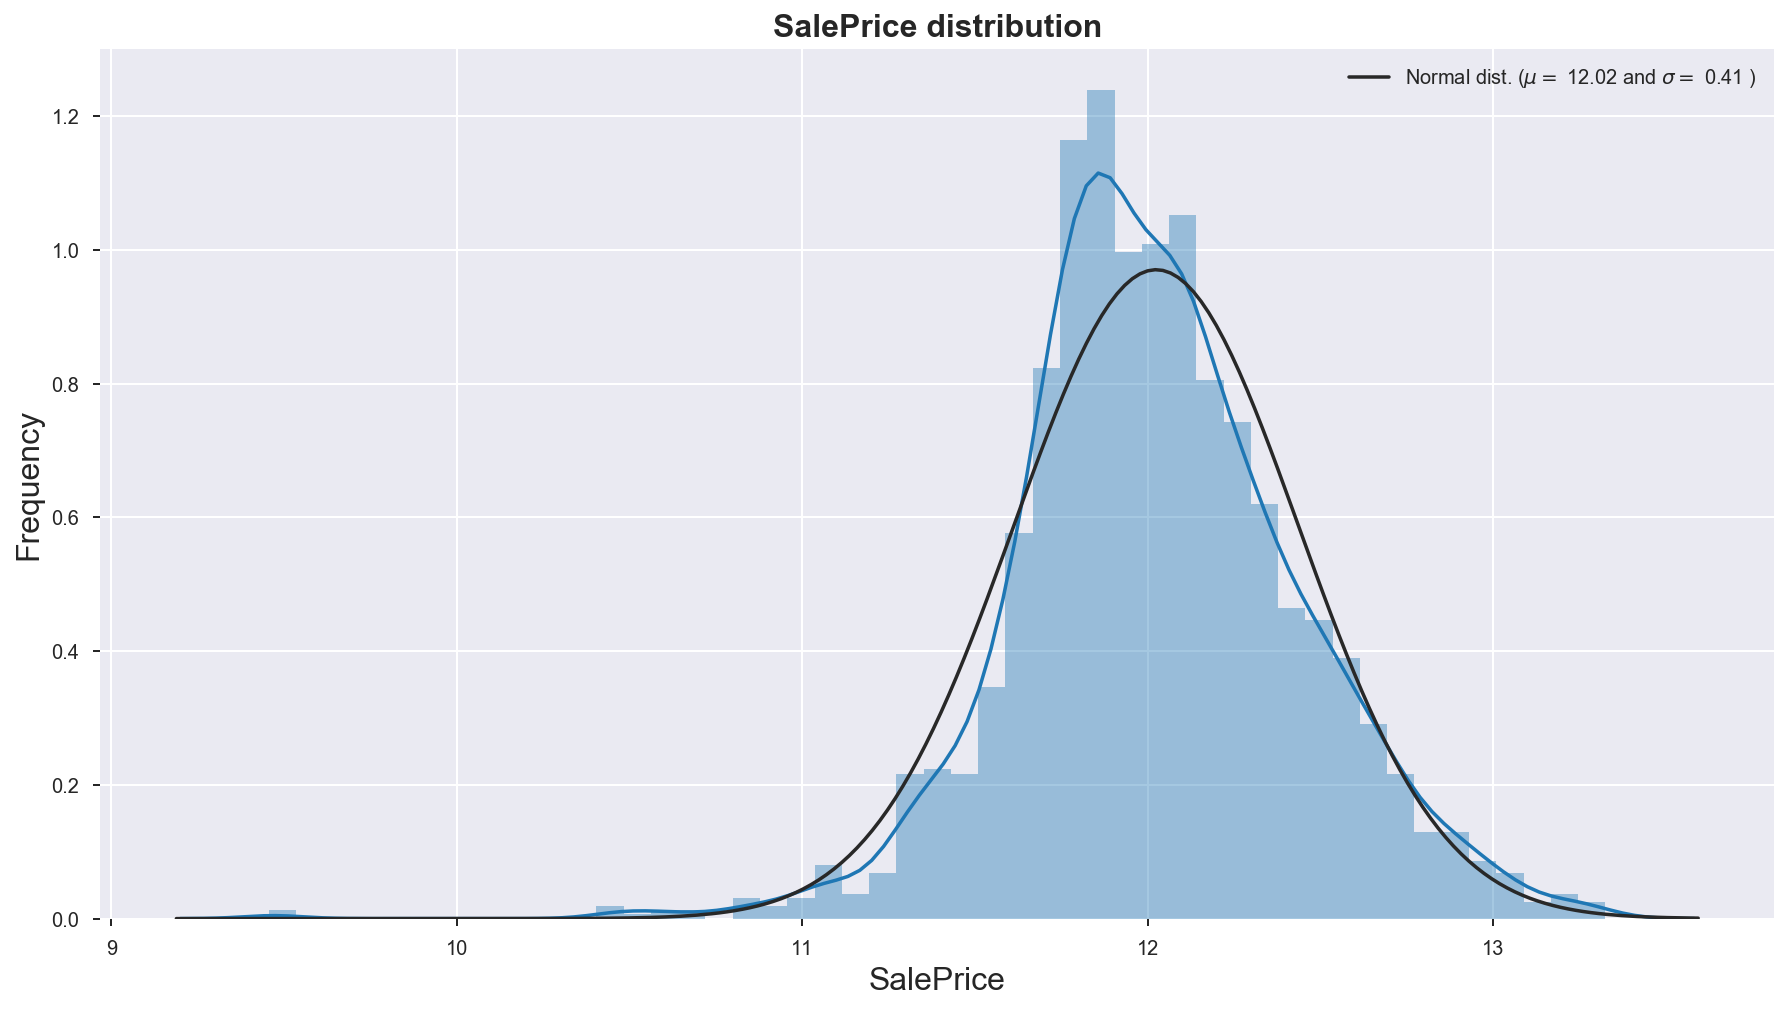

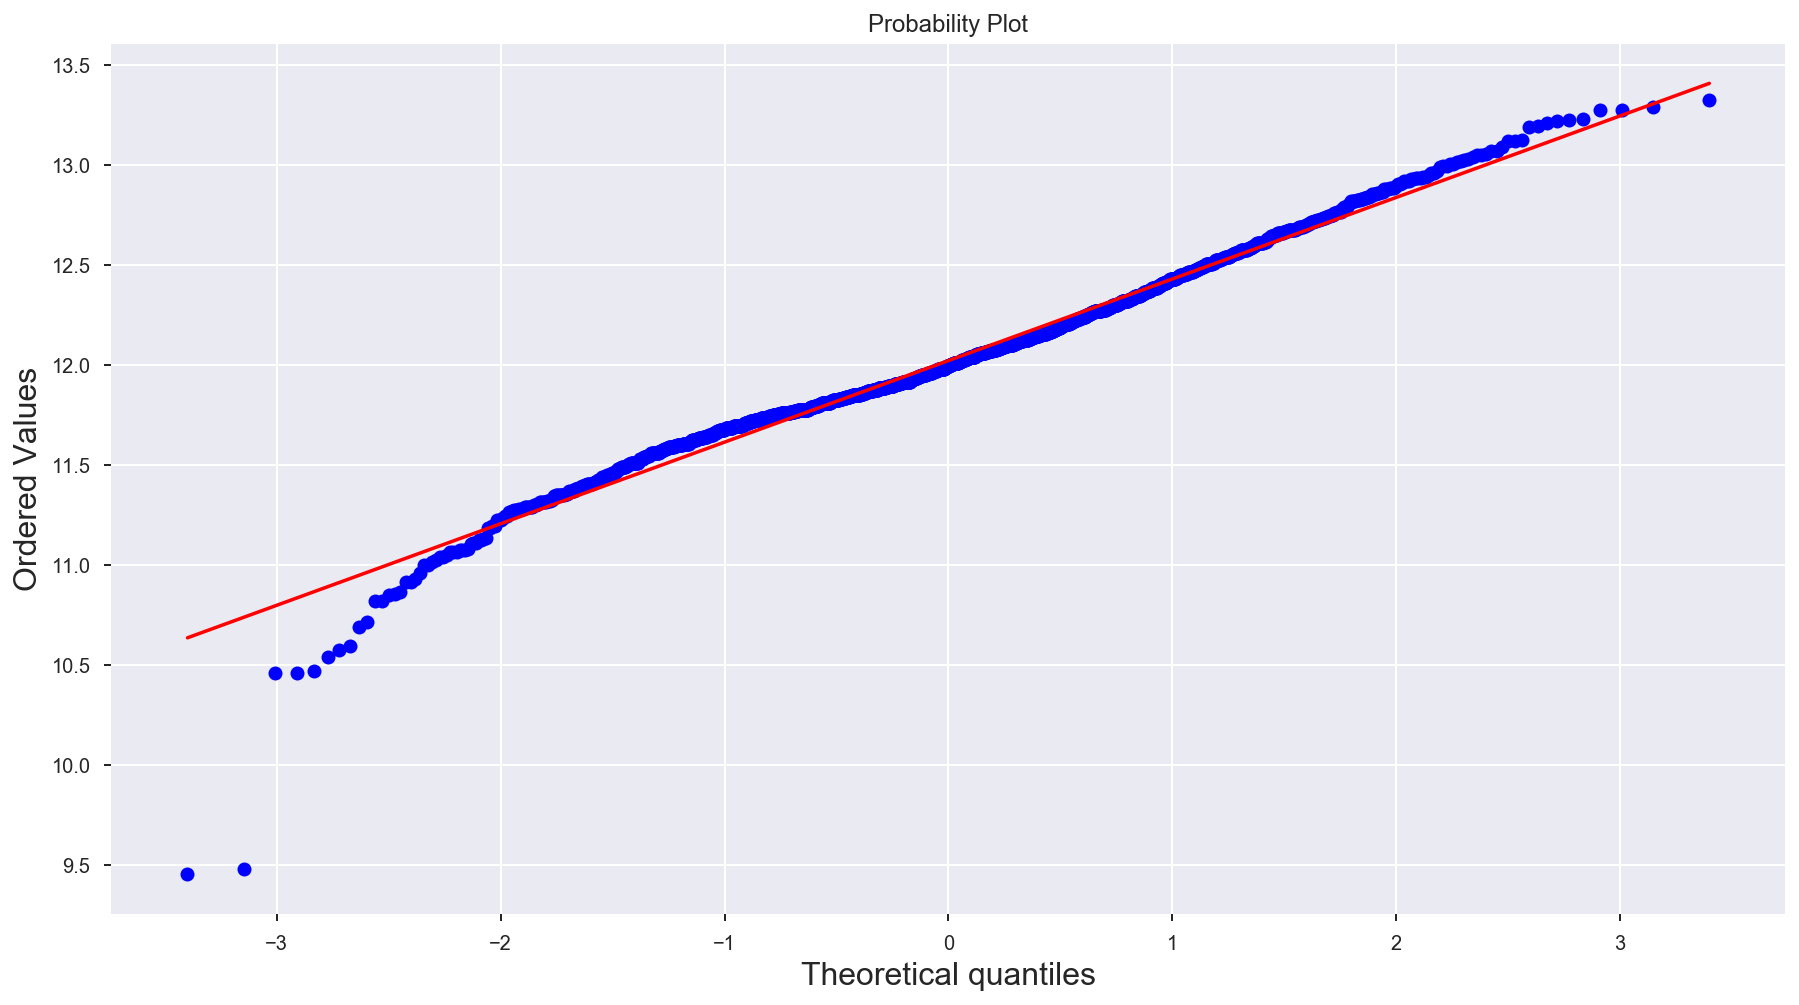

In [38]:
# Kernel Density Plot
plt.figure(figsize=(15,8))
plt.ylabel('Frequency',fontsize=16)
plt.xlabel('SalePrice',fontsize=16)
sns.distplot(train.SalePrice,fit=norm);
plt.title('SalePrice distribution',fontsize=16,fontweight='bold');
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice']);
# QQ-plot
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
fig = plt.figure(figsize=(15,8))
plt.ylabel('Ordered Values',fontsize=16)
plt.xlabel('Theoretical Qualities',fontsize=16)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The resulting dependent variable (Sale Price) appears more normally distributed. However, there appears to be extreme outliers.

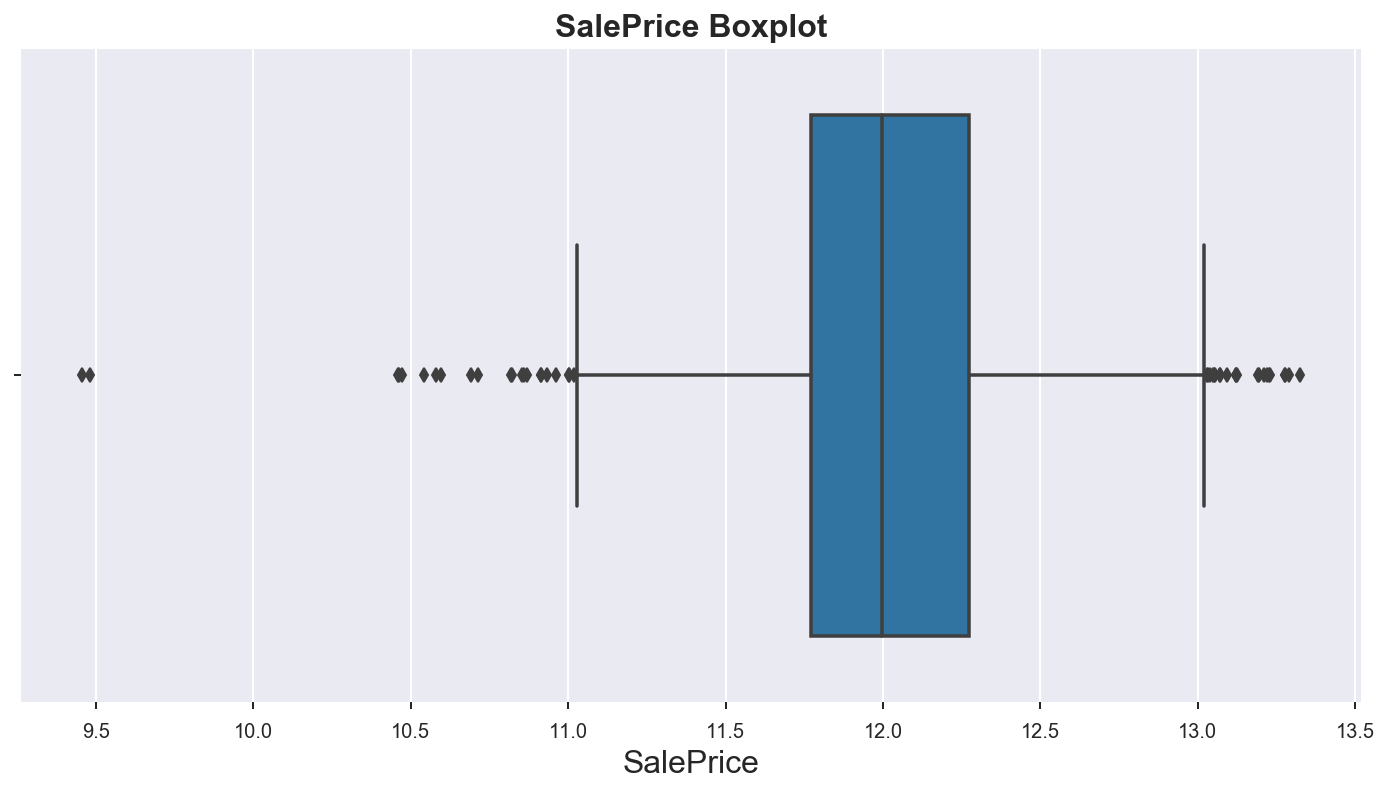

In [39]:
plt.figure(figsize=(12,6))
plt.title('SalePrice Boxplot',fontsize=16,fontweight='bold');
plt.xlabel('SalePrice',fontsize=16)
sns.boxplot(train['SalePrice']);
#Boxplot suggests that there are extreme outliers in the transformed target variable

In [40]:
#Removal of 2 anomalies in price where deviation is >5 sigma - 2044 observations left
train.drop(train[train['SalePrice']<10].index,inplace=True)

## 6. Feature Selection

In [41]:
#Finding top 20 strongly correlated features with Sale Price, ordered by descending order
corrmat = train.corr()
columns = abs(corrmat['SalePrice']).sort_values(ascending=False).head(20)
columns

SalePrice        1.000000
OverallQual      0.826328
GrLivArea        0.713856
ExterQual        0.699192
KitchenQual      0.687605
GarageCars       0.683164
GarageArea       0.673230
TotalBsmtSF      0.657135
BsmtQual         0.640914
1stFlrSF         0.631630
YearBuilt        0.631474
GarageFinish     0.606708
YearRemod/Add    0.605143
FullBath         0.570260
FireplaceQu      0.553663
TotRmsAbvGrd     0.505648
HeatingQC        0.502218
Fireplaces       0.493805
GarageYrBlt      0.461541
MasVnrArea       0.458314
Name: SalePrice, dtype: float64

In [42]:
#Finding top strongly correlated features with OverallQual
columns2 = abs(corrmat['OverallQual']).sort_values(ascending=False).head(20)
columns

SalePrice        1.000000
OverallQual      0.826328
GrLivArea        0.713856
ExterQual        0.699192
KitchenQual      0.687605
GarageCars       0.683164
GarageArea       0.673230
TotalBsmtSF      0.657135
BsmtQual         0.640914
1stFlrSF         0.631630
YearBuilt        0.631474
GarageFinish     0.606708
YearRemod/Add    0.605143
FullBath         0.570260
FireplaceQu      0.553663
TotRmsAbvGrd     0.505648
HeatingQC        0.502218
Fireplaces       0.493805
GarageYrBlt      0.461541
MasVnrArea       0.458314
Name: SalePrice, dtype: float64

Other than sales price, unsurprisingly, Externalqual, KitchenQual and BsmtQual are also strongly correlated with OverallQual, as the 3 features are complementary. It is important to consider whether we will need to drop these features later to minimize multicollinearity.

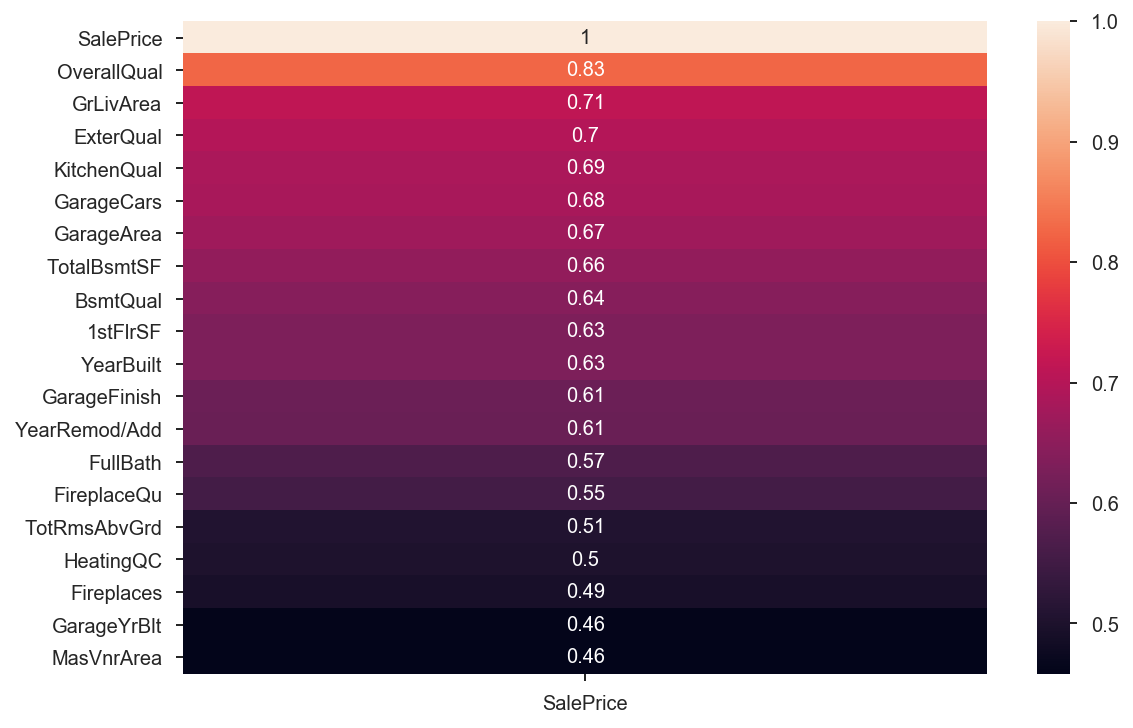

In [43]:
#Correlation heatmap of top 20 strongly correlated features with SalesPrice
plt.figure(figsize=(9,6))
sns.heatmap(pd.DataFrame(columns.head(20)),annot=True);

In [44]:
#pairplot to observe top 10 features that have strongest correlation with sales price
# sns.pairplot(train, vars = columns.head(10).index);

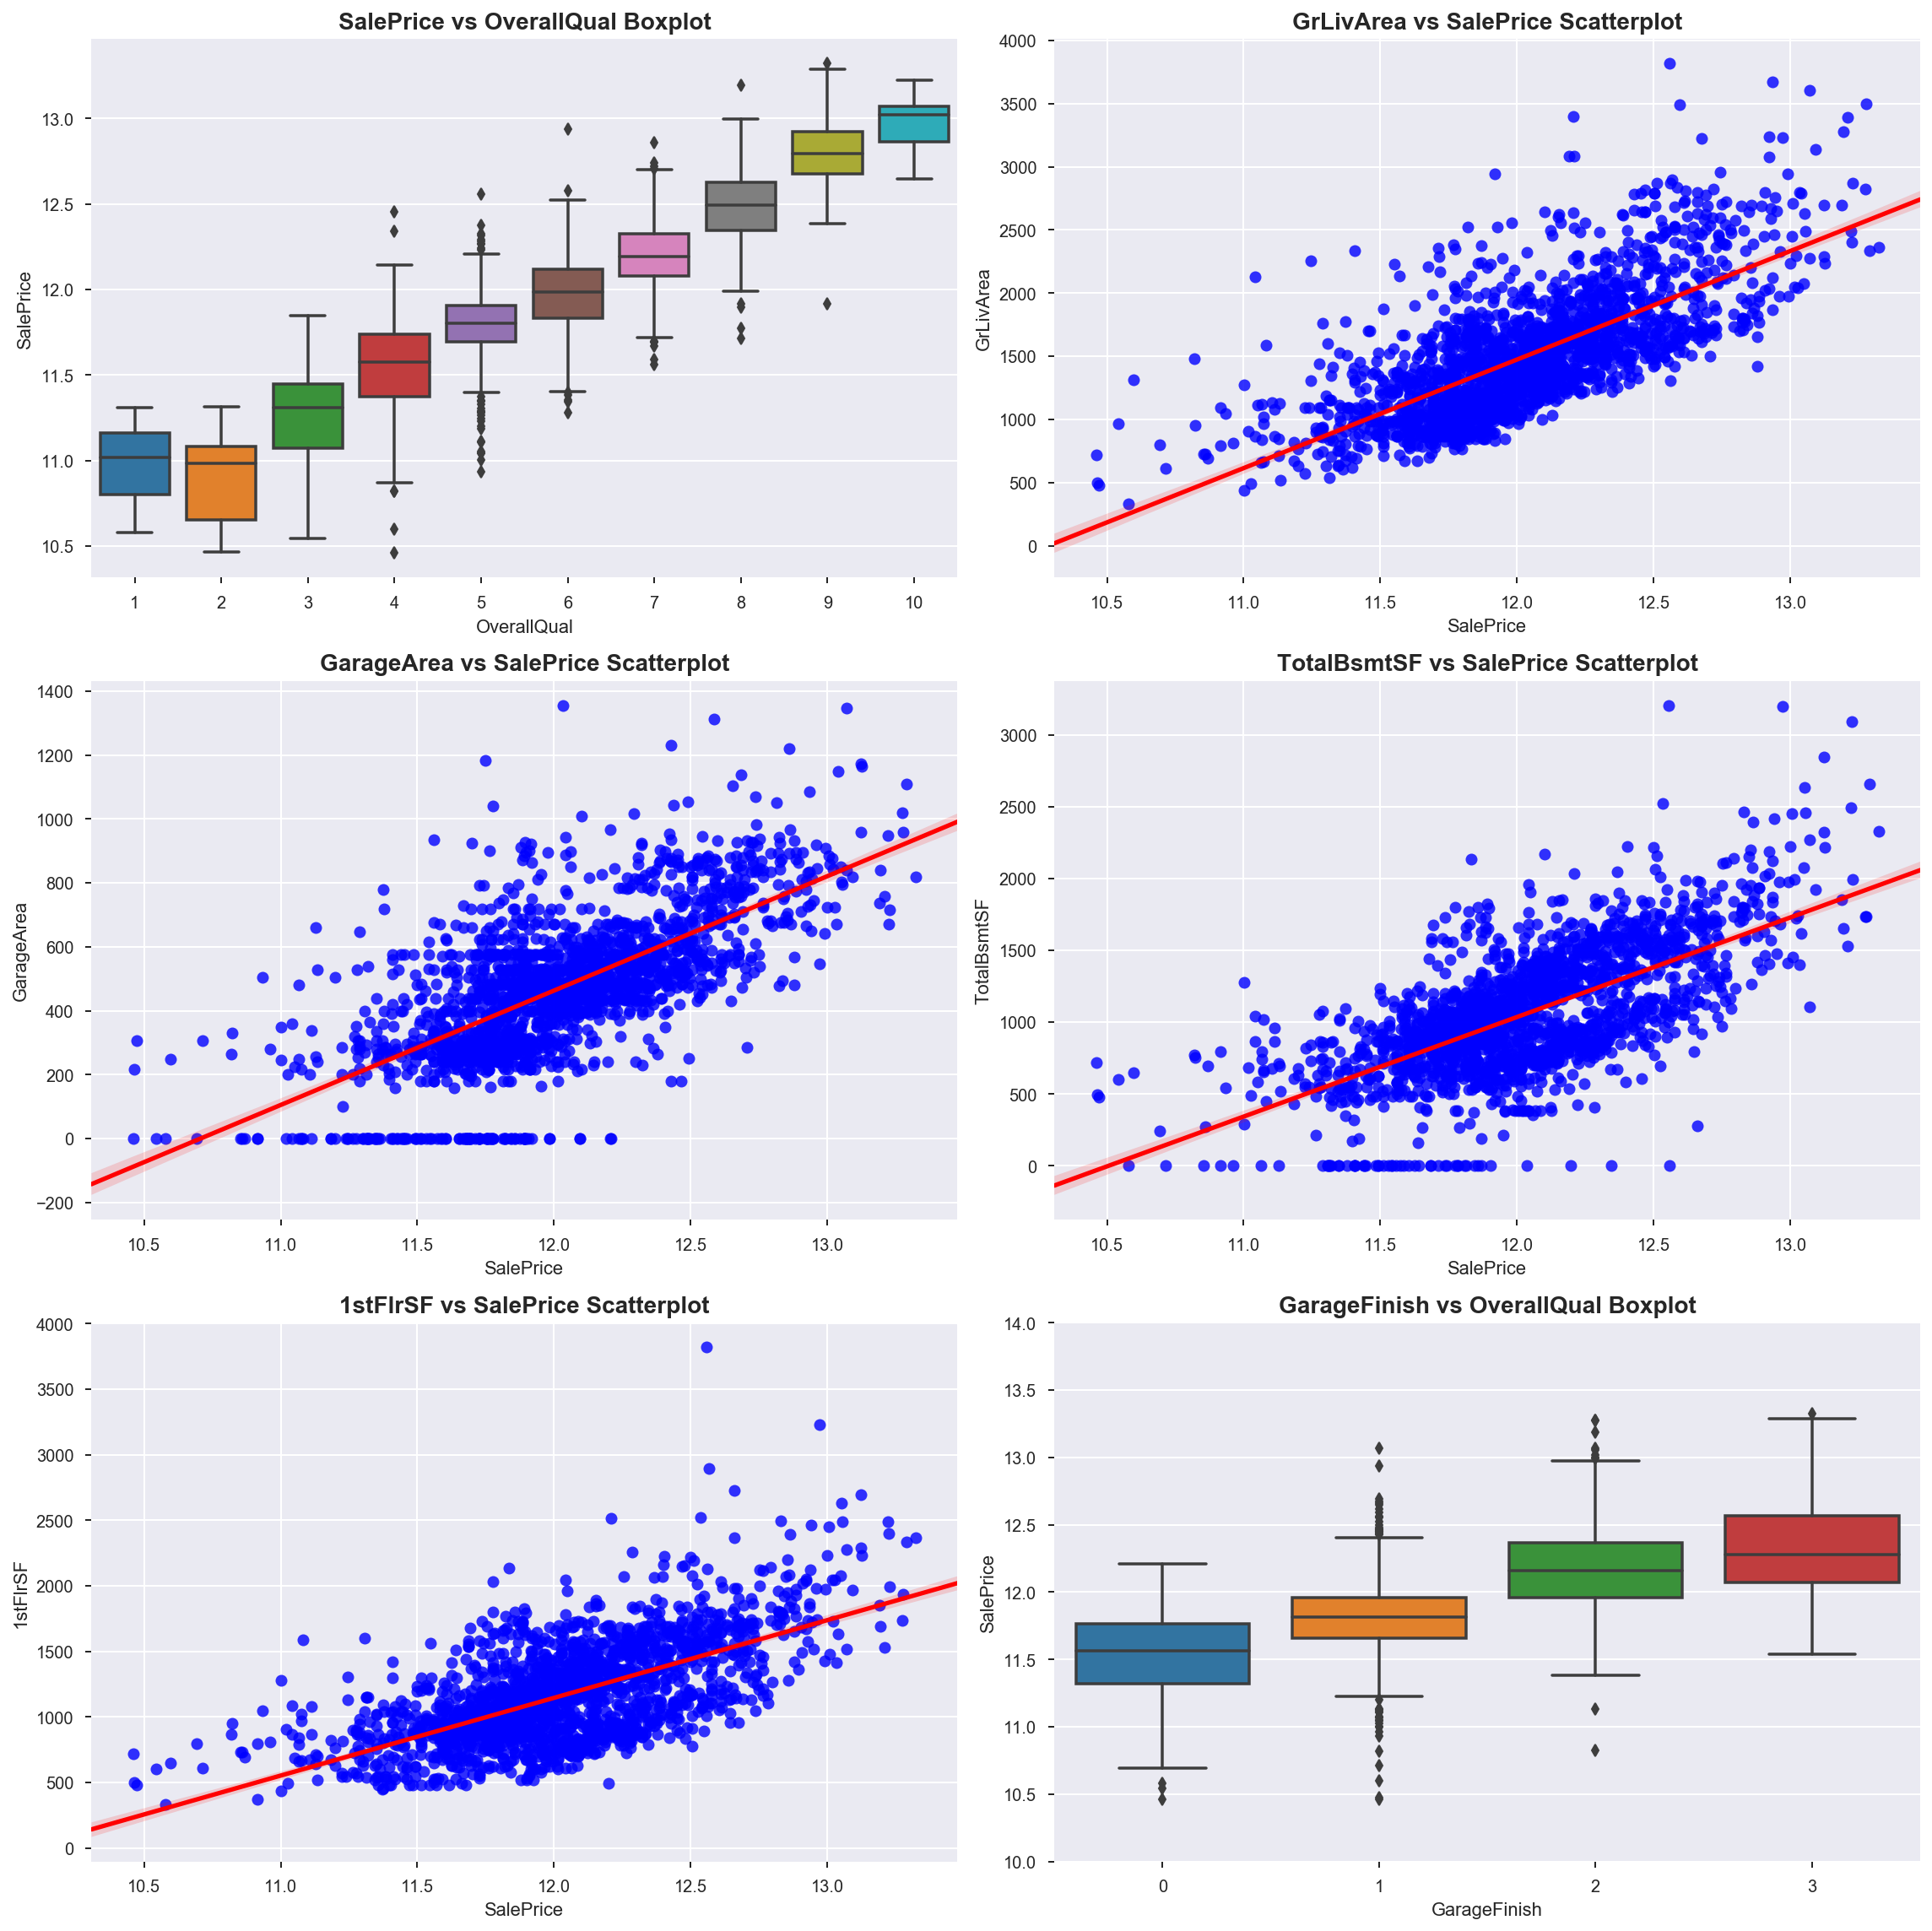

In [45]:
#Subplot to investigate deeper into top few eatures, and its relation with Salesprice
fig, axes = plt.subplots(3, 2,figsize=(16,16))

#Boxplot between OverallQual and SalesPrice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
axes[0][0].set_ylabel('SalePrice')
axes[0][0].set_xlabel('OverallQual')
axes[0][0].set_title('SalePrice vs OverallQual Boxplot',fontweight='bold',size=14)
fig = sns.boxplot(x=var, y="SalePrice",ax=axes[0][0], data=data)

#Scatterplot between GrLivArea and SalesPrice
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
axes[0][1].set_ylabel('GrLivArea')
axes[0][1].set_xlabel('SalePrice')
axes[0][1].set_title('GrLivArea vs SalePrice Scatterplot',fontweight='bold',size=14)
scat = sns.regplot(x="SalePrice", y=var, ax=axes[0][1], data=train,  scatter_kws={"color": "blue"}, line_kws={"color": "red"});

#Scatterplot between GarageArea and SalesPrice
var = 'GarageArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
axes[1][0].set_ylabel('GarageArea')
axes[1][0].set_xlabel('SalePrice')
axes[1][0].set_title('GarageArea vs SalePrice Scatterplot',fontweight='bold',size=14)
scat = sns.regplot(x="SalePrice", y=var, ax=axes[1][0], data=train,  scatter_kws={"color": "blue"}, line_kws={"color": "red"});

#Scatterplot between TotalBsmtSF and SalesPrice
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
axes[1][1].set_ylabel('TotalBsmtSF')
axes[1][1].set_xlabel('SalePrice')
axes[1][1].set_title('TotalBsmtSF vs SalePrice Scatterplot',fontweight='bold',size=14)
scat = sns.regplot(x="SalePrice", y=var, ax=axes[1][1], data=train,  scatter_kws={"color": "blue"}, line_kws={"color": "red"});

#Scatterplot between 1stFlrSF and SalesPrice
var = '1stFlrSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
axes[2][0].set_ylabel('1stFlrSF')
axes[2][0].set_xlabel('SalePrice')
axes[2][0].set_title('1stFlrSF vs SalePrice Scatterplot',fontweight='bold',size=14)
scat = sns.regplot(x="SalePrice", y=var, ax=axes[2][0], data=train,  scatter_kws={"color": "blue"}, line_kws={"color": "red"});

#Boxplot between GarageFinish and SalesPrice
var = 'GarageFinish'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
axes[2][1].set_ylabel('SalePrice')
axes[2][1].set_xlabel('GarageFinish')
axes[2][1].set_title('GarageFinish vs OverallQual Boxplot',fontweight='bold',size=14)
axes[2][1].set_ylim([10, 14]) 
fig = sns.boxplot(x=var, y="SalePrice",ax=axes[2][1], data=data)

plt.tight_layout()

As expected, there is strong apparent correlation between the selected features and sales price, seen especially in the scatterplots with small confidence intervals for the plotted line.

## 7. Modelling using Logistic Regression, LassoCV, RidgeCV

In [46]:
#assigning the top 20 correlated features that will be used for regression, in a modified variable
# A training model was established using the train.csv, with the test.csv as the variables to predict upon.
train_x = train[[x for x in columns.index if x != 'SalePrice']]
test_x = test[[x for x in columns.index if x != 'SalePrice']]

In [47]:
#Converting selected features with categorical values into dummy
train_x = pd.get_dummies(train_x)
test_x = pd.get_dummies(test_x)

In [48]:
#initiating, fitting and transforming using polynomial features
poly = PolynomialFeatures(include_bias=False)

train_x = poly.fit_transform(train_x)
test_x = poly.fit_transform(test_x)

In [49]:
print(test_x.shape)
print(train_x.shape)

(879, 209)
(2044, 209)


In [50]:
#initiating, fitting and transforming standard scaler
ss = StandardScaler()
train_x = ss.fit_transform(train_x)
test_x = ss.transform(test_x)

train_y = train['SalePrice']

In [57]:
#initiating linear regerssion, lasso and ridge, and cross-validated to find model with best fit.
lr = LinearRegression()
lasso = LassoCV(n_alphas=20)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 200))

lr_scores = cross_val_score(lr, train_x, train_y, cv=3)
print('Linear Regression Rsquared score is {}'.format(lr_scores.mean()))

lasso_scores = cross_val_score(lasso, train_x, train_y, cv=3)
print('Lasso Regression Rsquared score is {}'.format(lasso_scores.mean()))

ridge_scores = cross_val_score(ridge, train_x, train_y, cv=3)
print('Ridge Regression Rsquared score is {}'.format(ridge_scores.mean()))

Linear Regression Rsquared score is 0.8551240318251593
Lasso Regression Rsquared score is 0.8816184212821311
Ridge Regression Rsquared score is 0.8820613265081846


Ridge Regression appears to perform best amongst the 3 models. For our prediction, we'll be using the model.

Score is 0.8988085068633902


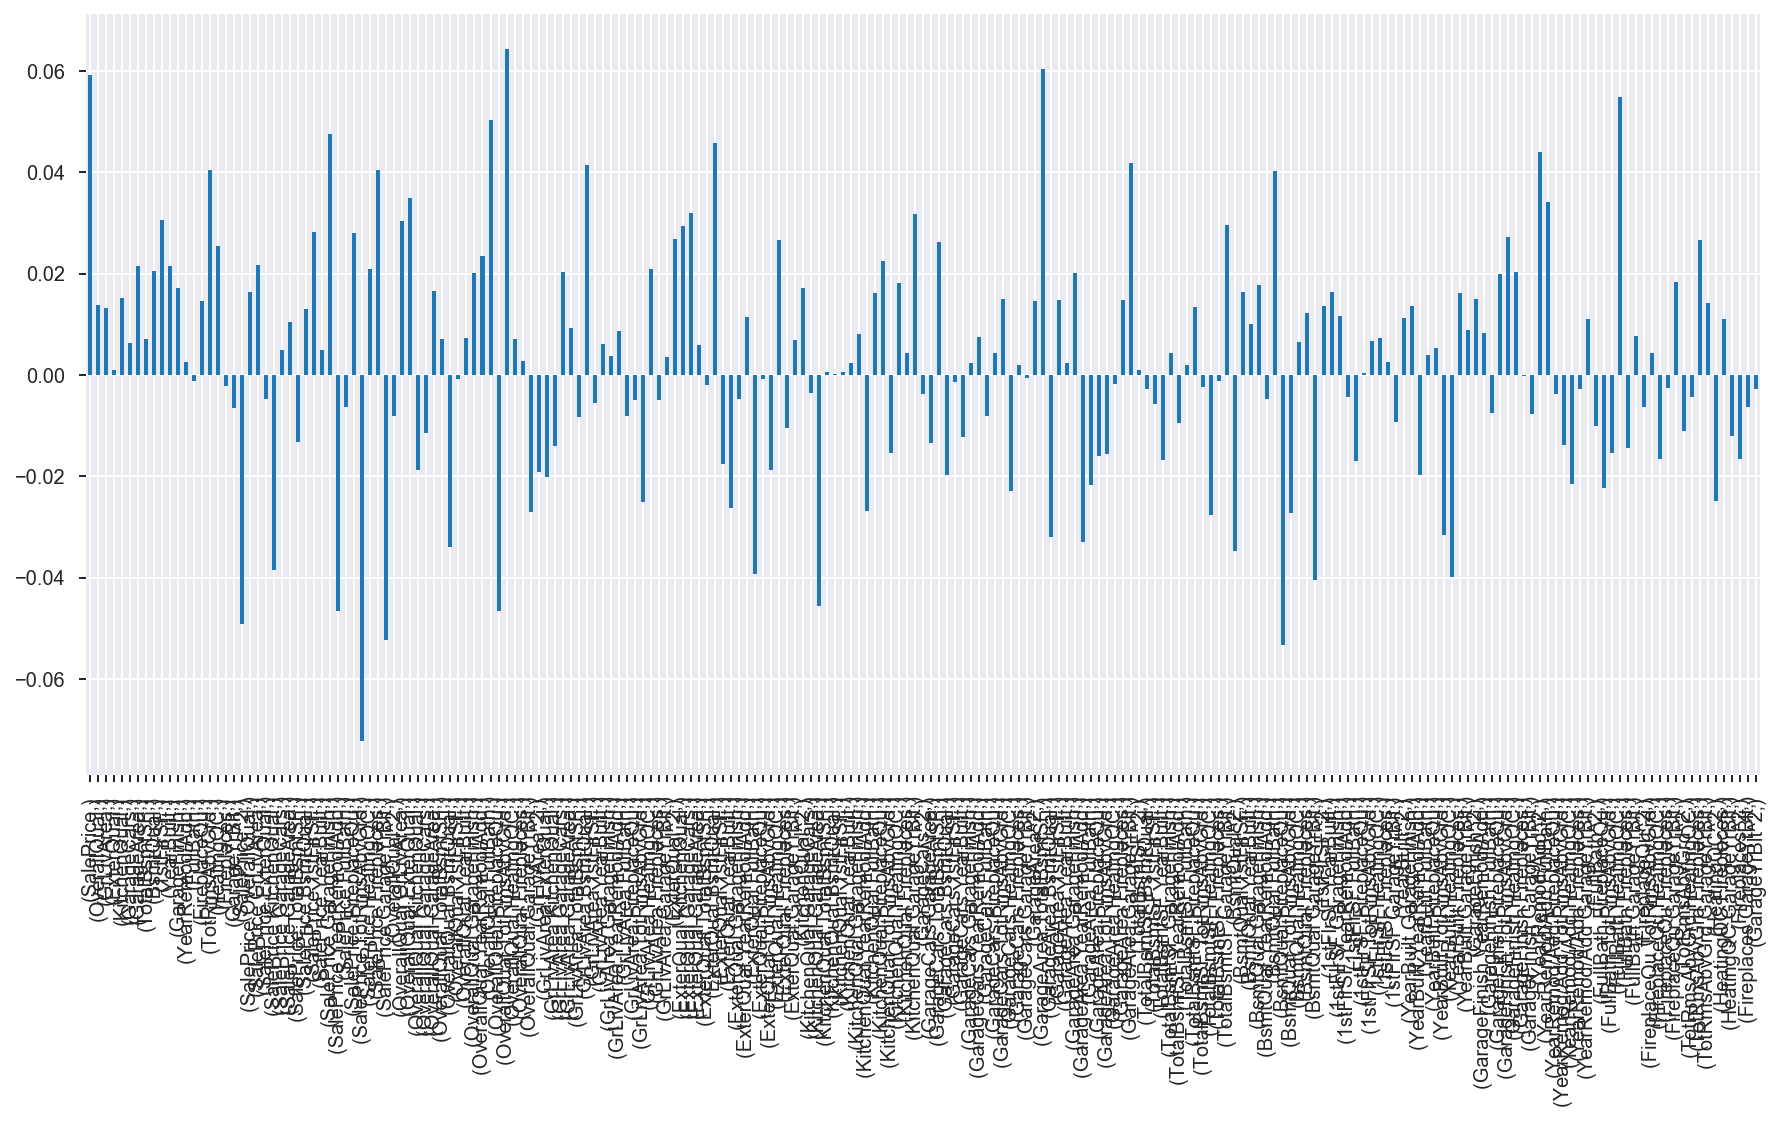

In [52]:
#Establishing a Ridge model, with its score
ridge.fit(train_x, train_y)
print('Score is {}'.format(ridge.score(train_x, train_y)))

#Creating a prediction using Lasso, storing it into the pred variable
pred = np.expm1(ridge.predict(test_x))
pred

#Visualisation of coefficients (with polynomnial)
pd.Series(ridge.coef_, index=[poly.get_feature_names(columns.index)]).plot.bar(figsize=(15, 7));

## 8. For submission

In [53]:
def submission_df(predict):
    df = pd.DataFrame(test['Id'])
    df['SalePrice'] = predict
    df.set_index(['Id'], inplace = True)
    df.to_csv('answer.csv')
    print (df)

In [54]:
submission_df(pred)

          SalePrice
Id                 
2658  135969.547142
2718  180636.241688
2414  179740.839479
1989  121141.749182
625   188406.393933
333    97480.450105
1327  115312.631333
858   147166.182522
95    187509.848873
1568  165172.090871
2482  166022.594009
1364  123474.821453
2584  159015.940600
818   289071.799388
2673  152988.611057
2089  137021.887768
1297  158131.688686
790   117431.411320
2616  196206.853201
720   175614.749060
222   142270.565251
557   122558.653409
1148  216348.925970
2766  155228.273076
534   200886.828171
1452  111689.251557
630   145393.508414
2648  119643.480603
125   142096.046501
1904   62741.448750
...             ...
933   126555.568687
2784  143410.258923
972   177935.408475
599   157297.205605
2614  116964.043240
2582  146556.023298
1409  152724.111227
175   103083.536340
352   201348.445144
976    95822.206887
2134  196970.103695
984   109015.059126
2396  384057.163213
1673  145062.194682
404   126240.918286
607   167943.375739
814   187058.642812


Final submission score on Kaggle:

Public Score: 26,210

Private Score: 32,936